### Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980 по июль 1995, необходимо построить прогноз на следующие два года.

<img src="http://s6.postimg.org/xyjegcv01/image.jpg"></img>

In [24]:
library(forecast)
library(tseries)
library(lmtest)
library(Hmisc)

options(repr.plot.width = 8, repr.plot.height = 4)

In [11]:
data <- read.csv("./winesales 2/monthly-australian-wine-sales-th.csv", sep=",", stringsAsFactors=F)
data <- head(data, -1)
names(data)[1] <- "Date"
names(data)[2] <- "Value"
xname <- "Monthly Australian wine sales: thousands of litres"

In [13]:
data[1:5, ]

Date,Value
1980-01,15136
1980-02,16733
1980-03,20016
1980-04,17708
1980-05,18019


Преобразование даты

In [16]:
data$Value <- as.numeric(data$Value)
data$Date <- as.Date(as.yearmon(data$Date, format="%Y-%m"))

In [17]:
data[1:5, ]

Date,Value
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019


Создание объекта "временной ряд"

In [18]:
tSeries <- ts(data = data$Value, 
              start = as.numeric(c(format(data$Date[1], "%Y"), format(data$Date[1], "%m"))), 
              freq = 12)

In [20]:
tSeries

       Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec
1980 15136 16733 20016 17708 18019 19227 22893 23739 21133 22591 26786 29740
1981 15028 17977 20008 21354 19498 22125 25817 28779 20960 22254 27392 29945
1982 16933 17892 20533 23569 22417 22084 26580 27454 24081 23451 28991 31386
1983 16896 20045 23471 21747 25621 23859 25500 30998 24475 23145 29701 34365
1984 17556 22077 25702 22214 26886 23191 27831 35406 23195 25110 30009 36242
1985 18450 21845 26488 22394 28057 25451 24872 33424 24052 28449 33533 37351
1986 19969 21701 26249 24493 24603 26485 30723 34569 26689 26157 32064 38870
1987 21337 19419 23166 28286 24570 24001 33151 24878 26804 28967 33311 40226
1988 20504 23060 23562 27562 23940 24584 34303 25517 23494 29095 32903 34379
1989 16991 21109 23740 25552 21752 20294 29009 25500 24166 26960 31222 38641
1990 14672 17543 25453 32683 22449 22316 27595 25451 25421 25288 32568 35110
1991 16052 22146 21198 19543 22084 23816 29961 26773 26635 26972 30207 38687

График данного временного ряда

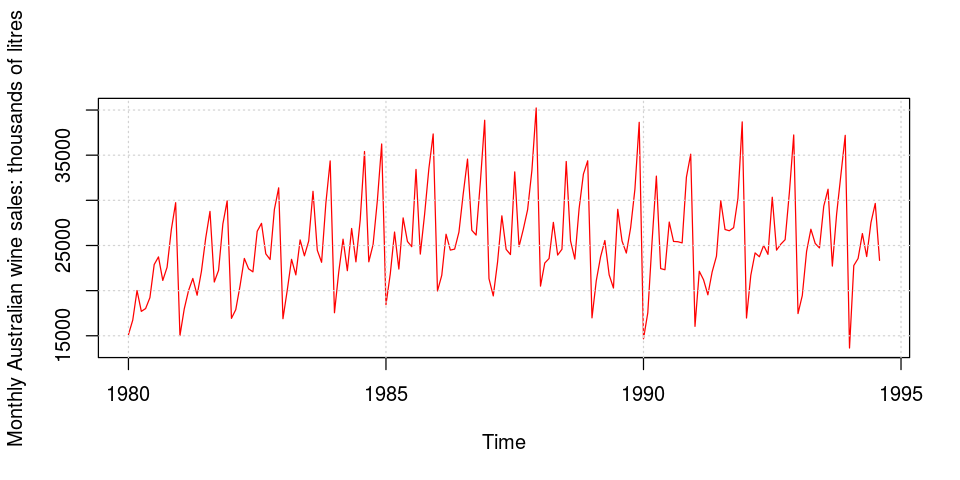

In [25]:
plot(tSeries, type="l", ylab=xname, col="red")
grid()

Разбиение на train и test. Все, что до августа 1992 года -- train; все, что после -- test.

In [26]:
trainSeries <- window(tSeries, end=c(1992,8))
testSeries  <- window(tSeries, start=c(1992,9))
D <- 24

Попробуем поделить на число дней в месяце:

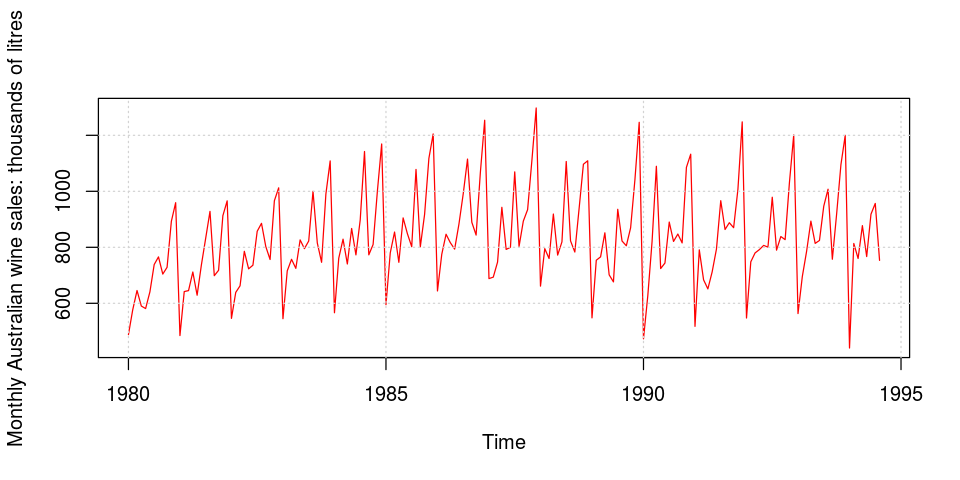

In [33]:
plot(tSeries / monthDays(as.Date(time(tSeries))), type="l", ylab=xname, col="red")
grid()

Ряд не стал более регулярным, так что вернёмся к исходным данным.

STL-декомпозиция ряда:

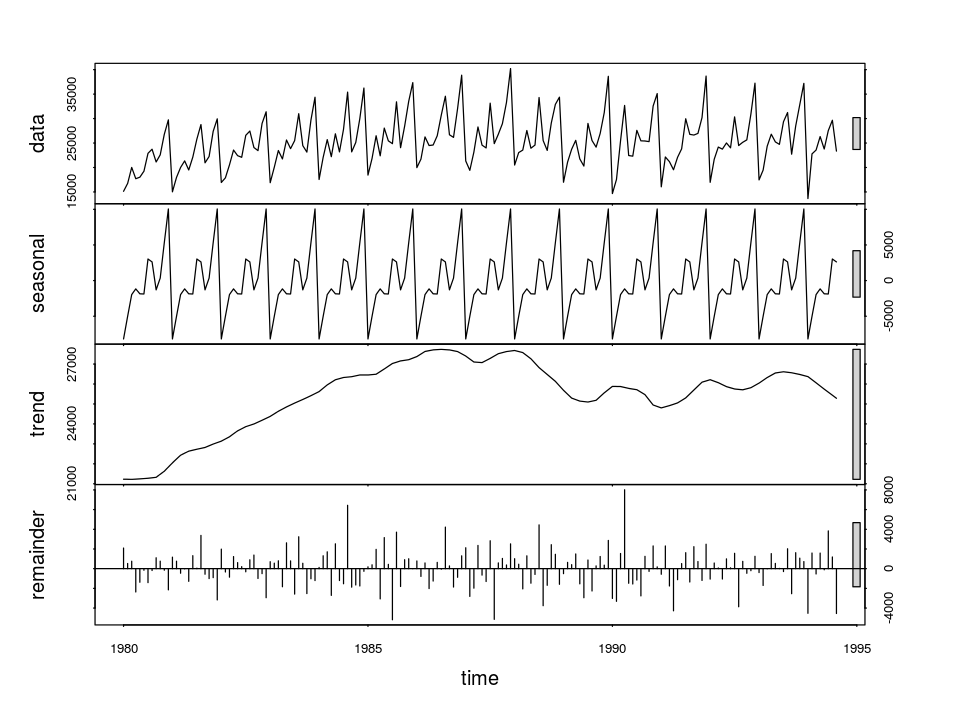

In [39]:
options(repr.plot.width = 8, repr.plot.height = 6)

stl.decompose = stl(tSeries, s.window="periodic")
plot(stl.decompose)

In [46]:
stl.decompose

 Call:
 stl(x = tSeries, s.window = "periodic")

Components
           seasonal    trend     remainder
Jan 1980 -8189.5356 21231.13  2094.4066223
Feb 1980 -5020.2042 21226.89   526.3112276
Mar 1980 -1963.1375 21222.66   756.4806386
Apr 1980 -1162.5102 21235.08 -2364.5728849
May 1980 -1853.4832 21247.51 -1375.0261245
Jun 1980 -1879.0503 21262.32  -156.2735124
Jul 1980  3031.9191 21277.14 -1416.0572886
Aug 1980  2622.2221 21301.27  -184.4961242
Sep 1980 -1299.3207 21325.41  1106.9108855
Oct 1980   351.8026 21477.19   762.0034491
Nov 1980  5308.7832 21628.98  -151.7613506
Dec 1980 10052.5149 21837.79 -2150.3096025
Jan 1981 -8189.5356 22046.61  1170.9244180
Feb 1981 -5020.2042 22239.07   758.1388897
Mar 1981 -1963.1375 22431.52  -460.3818328
Apr 1981 -1162.5102 22533.04   -16.5341462
May 1981 -1853.4832 22634.57 -1283.0861757
Jun 1981 -1879.0503 22683.66  1320.3869997
Jul 1981  3031.9191 22732.76    52.3237867
Aug 1981  2622.2221 22776.76  3380.0150174
Sep 1981 -1299.3207 22820.77  -561.44

Оптимальное преобразование Бокса-Кокса и результат его применения:

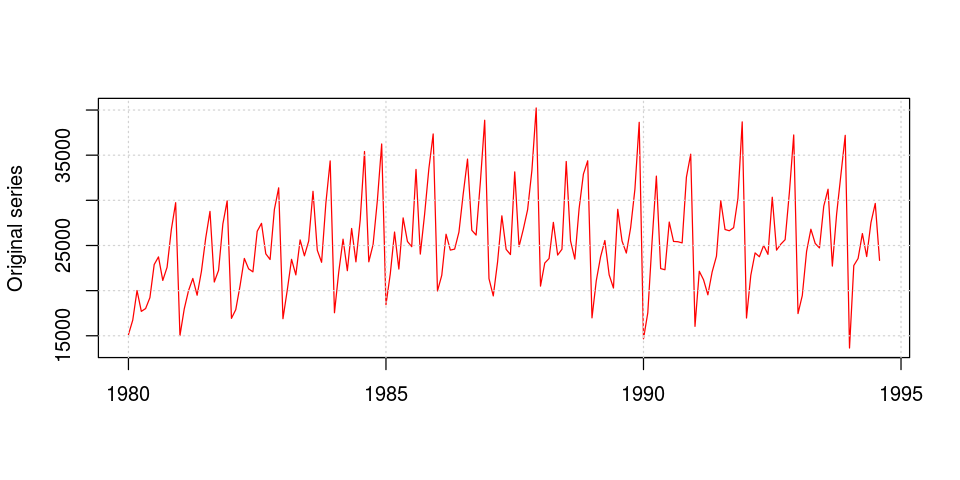

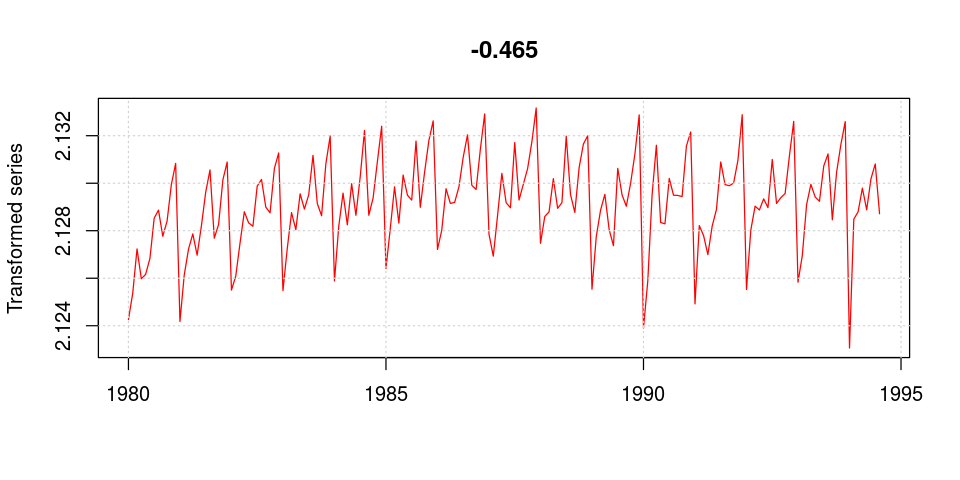

In [50]:
options(repr.plot.width = 8, repr.plot.height = 4)


plot(tSeries, ylab="Original series", xlab="", col="red")
grid()

LambdaOpt <- BoxCox.lambda(tSeries)
plot(BoxCox(tSeries, LambdaOpt), ylab="Transformed series", xlab="", col="red")
title(main=toString(round(LambdaOpt, 3)))
grid()

Ряд не выглядит существенно более стационарным, так что откажемся от преобразования Бокса-Кокса.

## Прогноз ETS

In [51]:
fitETS <- ets(tSeries)
print(fitETS)

ETS(M,Ad,M) 

Call:
 ets(y = tSeries) 

  Smoothing parameters:
    alpha = 0.0325 
    beta  = 0.0114 
    gamma = 2e-04 
    phi   = 0.974 

  Initial states:
    l = 20530.7127 
    b = 134.1851 
    s=1.3849 1.205 1.0104 0.9477 1.1229 1.1161
           0.9227 0.9249 0.9627 0.9233 0.8017 0.6777

  sigma:  0.0828

     AIC     AICc      BIC 
3632.532 3636.889 3689.601 


In [52]:
tSeries

       Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec
1980 15136 16733 20016 17708 18019 19227 22893 23739 21133 22591 26786 29740
1981 15028 17977 20008 21354 19498 22125 25817 28779 20960 22254 27392 29945
1982 16933 17892 20533 23569 22417 22084 26580 27454 24081 23451 28991 31386
1983 16896 20045 23471 21747 25621 23859 25500 30998 24475 23145 29701 34365
1984 17556 22077 25702 22214 26886 23191 27831 35406 23195 25110 30009 36242
1985 18450 21845 26488 22394 28057 25451 24872 33424 24052 28449 33533 37351
1986 19969 21701 26249 24493 24603 26485 30723 34569 26689 26157 32064 38870
1987 21337 19419 23166 28286 24570 24001 33151 24878 26804 28967 33311 40226
1988 20504 23060 23562 27562 23940 24584 34303 25517 23494 29095 32903 34379
1989 16991 21109 23740 25552 21752 20294 29009 25500 24166 26960 31222 38641
1990 14672 17543 25453 32683 22449 22316 27595 25451 25421 25288 32568 35110
1991 16052 22146 21198 19543 22084 23816 29961 26773 26635 26972 30207 38687

Настроив выбранную модель на обучающей выборке, посчитаем её качество на тестовой:

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,461.9271,2370.138,1830.385,1.061775,7.290815,0.9319881,0.05131647,NA
Test set,552.7241,2101.144,1630.480,1.011841,6.740578,0.8302017,-0.20524470,0.3129822


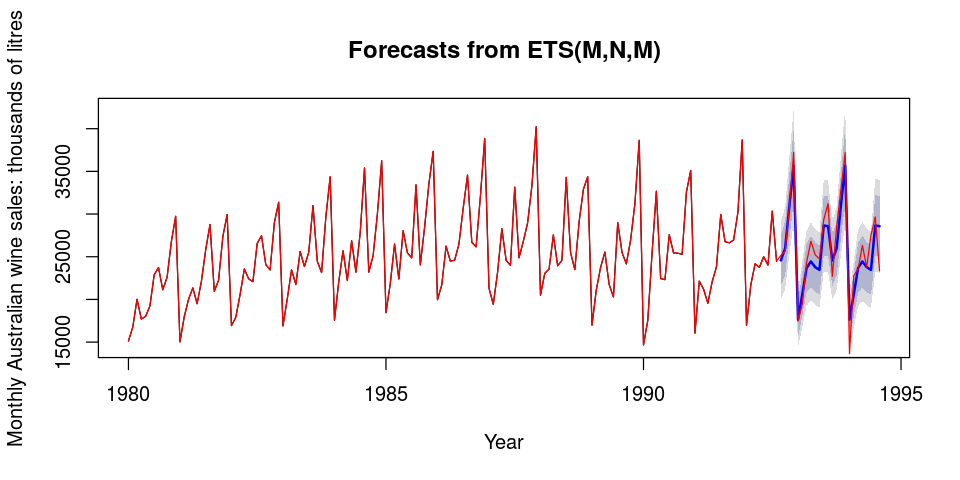

In [53]:
fitShort <- ets(trainSeries, model="MNM", damped=F)
fc <- forecast(fitShort, h=D)
accuracy(fc, testSeries)

plot(forecast(fitShort, h=D), ylab=xname, xlab="Year")
lines(tSeries, col="red")

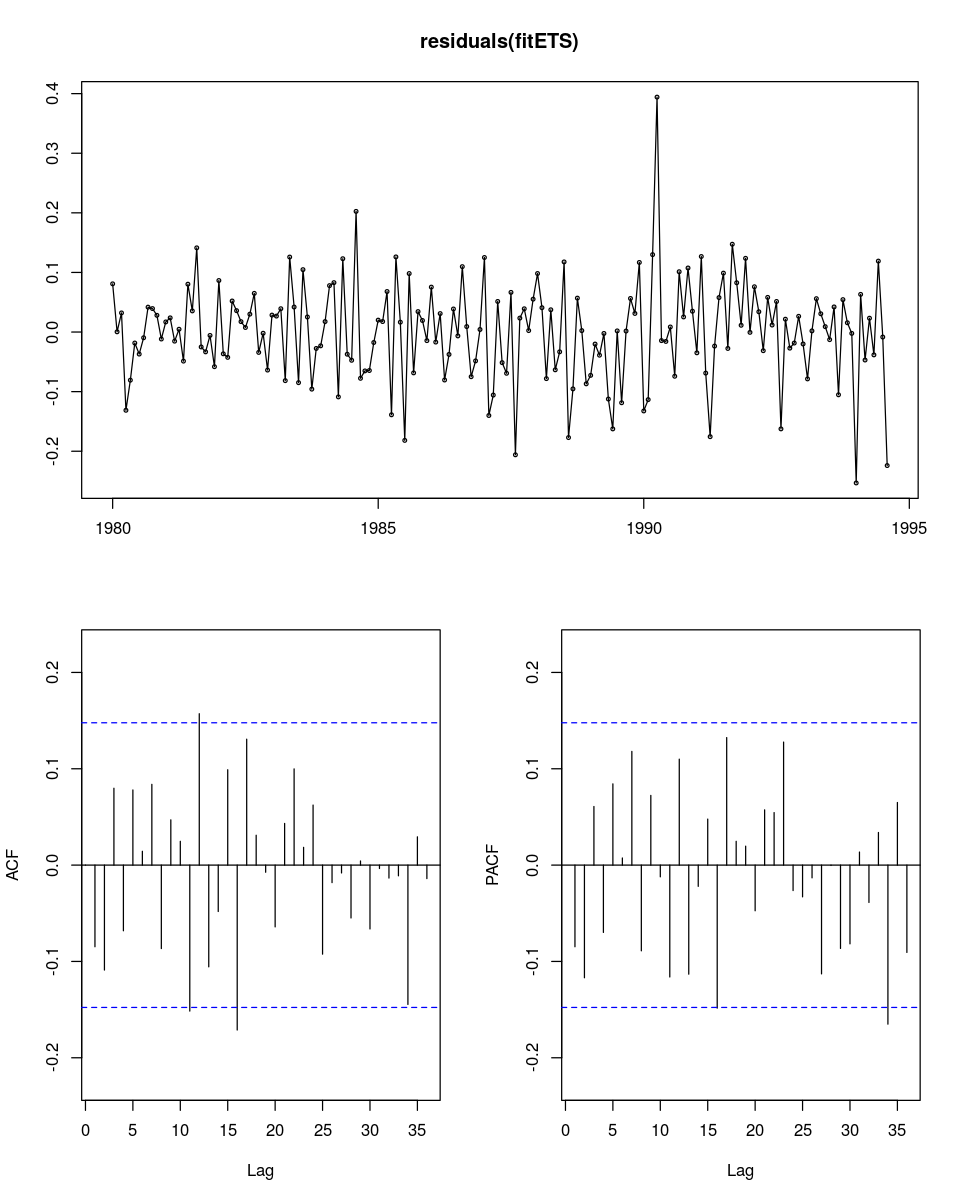

In [55]:
options(repr.plot.width = 8, repr.plot.height = 10)

tsdisplay(residuals(fitETS))

Достигаемые уровни значимости критерия Льюнга-Бокса для них:

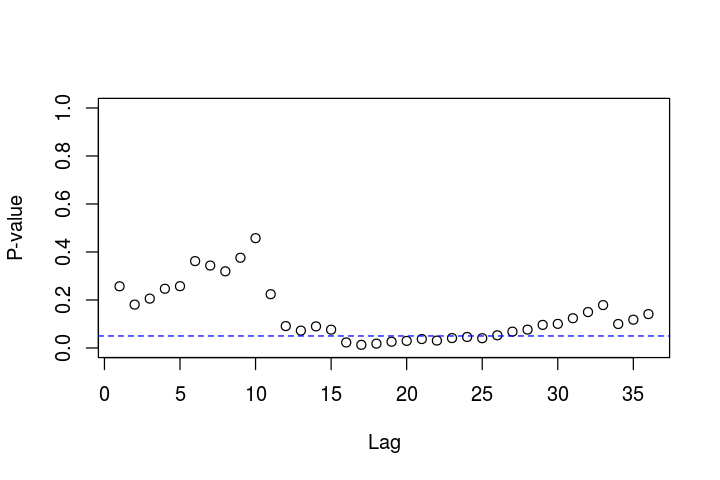

In [72]:
options(repr.plot.width = 6, repr.plot.height = 4)

p <- rep(0, 1, frequency(tSeries)*3)
for (i in 1:length(p)){
  p[i] <- Box.test(residuals(fitETS), lag=i, type = "Ljung-Box")$p.value
}

plot(p, xlab="Lag", ylab="P-value", ylim=c(0,1))
abline(h = 0.05, lty = 2, col = "blue")

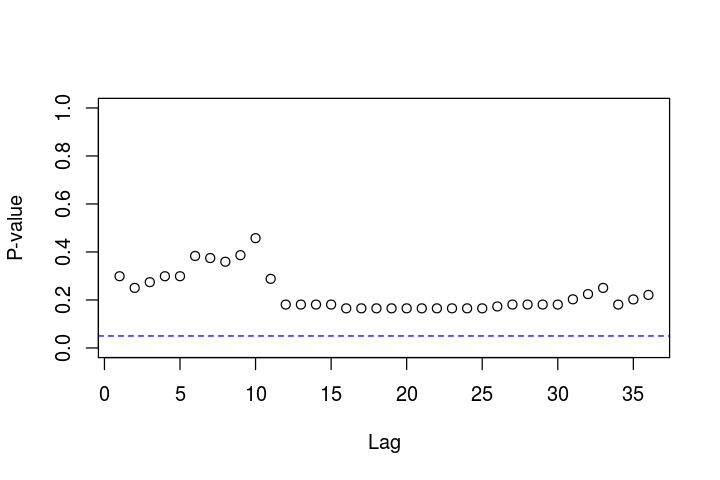

In [73]:
corrected_pvals <- p.adjust(p, method = 'BH')
plot(corrected_pvals, xlab="Lag", ylab="P-value", ylim=c(0,1))
abline(h = 0.05, lty = 2, col = "blue")

Q-Q plot и гистограмма для остатков:

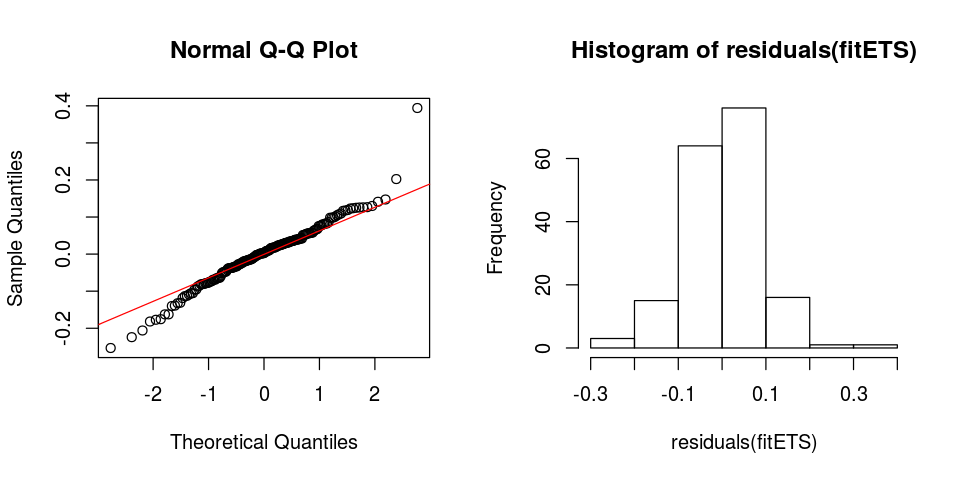

In [75]:
options(repr.plot.width = 8, repr.plot.height = 4)

par(mfrow=c(1,2))
qqnorm(residuals(fitETS))
qqline(residuals(fitETS), col="red")
hist(residuals(fitETS))

* Нормальность --- критерий Шапиро-Уилка
* Несмещённость --- критерий Уилкоксона
* Стационарность --- критерий KPSS
* Гомоскедастичность --- критерий Бройша-Пагана 

In [77]:
shapiro.test(residuals(fitETS))$p.value
wilcox.test(residuals(fitETS))$p.value
kpss.test(residuals(fitETS))$p.value
bptest(residuals(fitETS) ~ c(1:length(residuals(fitETS))))$p.value

[1] 0.0003462898

[1] 0.7146357

Warning message in kpss.test(residuals(fitETS)):
“p-value greater than printed p-value”

[1] 0.1

BP 
0.06989184

* Нормальность --- отвергается
* Несмещённость --- не отвергается
* Стационарность --- не отвергается
* Гомоскедастичность --- не отвергается 

<img src="http://topprioritys.appspot.com/u?purl=Z25wLmd2cy4xQSUwRCUxQSUwRCVGOSUwRCVBOSUwRCUteHA2MjMvZ3ZzLjFBJTBEJTFBJTBEJUY5%0AJTBEJUE5JTBEJS9lZi9mL2JtdWh0L3Nub21tb2MvYWlkZXBpa2l3L2dyby5haWRlbWlraXcuZGFv%0AbHB1Ly86c3B0dGg%3D%0A"></img>

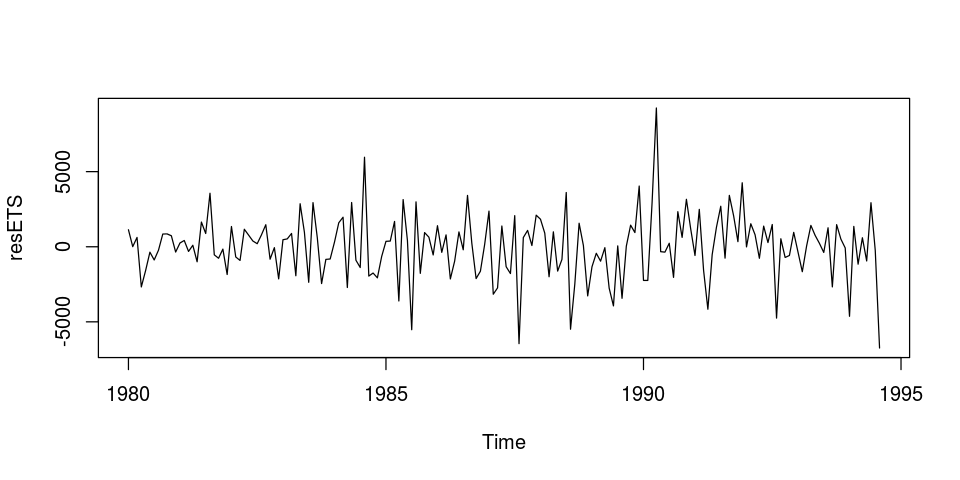

In [79]:
resETS  <- tSeries - fitETS$fitted
plot(resETS)

## ARIMA
### Ручной подбор модели

In [80]:
kpss.test(tSeries)$p.value

Warning message in kpss.test(tSeries):
“p-value smaller than printed p-value”

[1] 0.01

Исходный ряд нестационарен; сделаем сезонное дифференцирование:

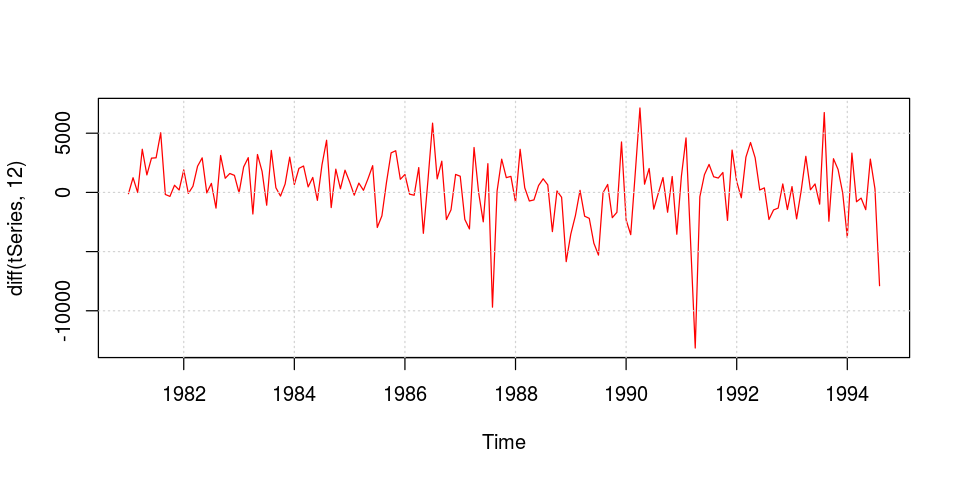

In [81]:
plot(diff(tSeries, 12), type="l", col="red")
grid()

In [84]:
round(kpss.test(diff(tSeries, 12))$p.value, 4)

[1] 0.0101

Ряд всё ещё нестационарен. Проведём ещё одно дифференцирование:

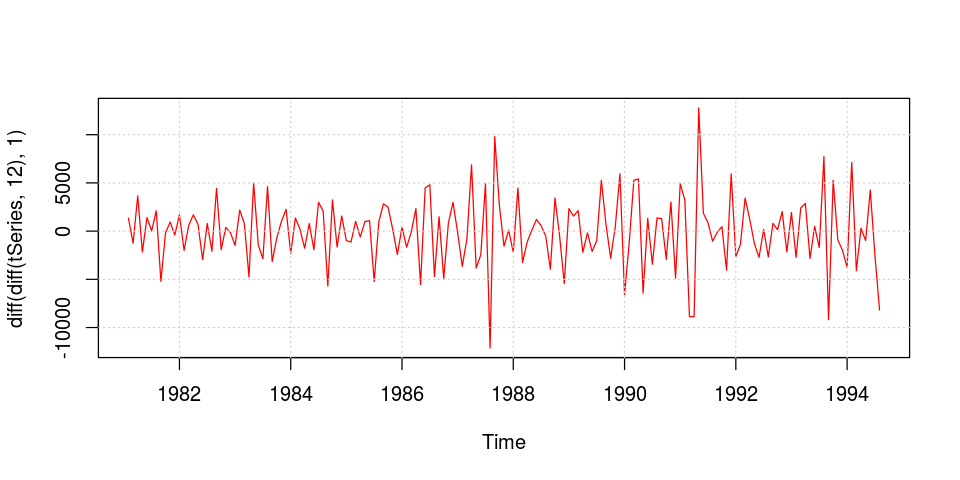

In [85]:
plot(diff(diff(tSeries, 12), 1), type="l", col="red")
grid()

In [86]:
kpss.test(diff(diff(tSeries, 12), 1))$p.value

Warning message in kpss.test(diff(diff(tSeries, 12), 1)):
“p-value greater than printed p-value”

[1] 0.1

Для полученного ряда гипотеза стационарности не отвергается.

Посмотрим на ACF и PACF полученного продифференцированного ряда:

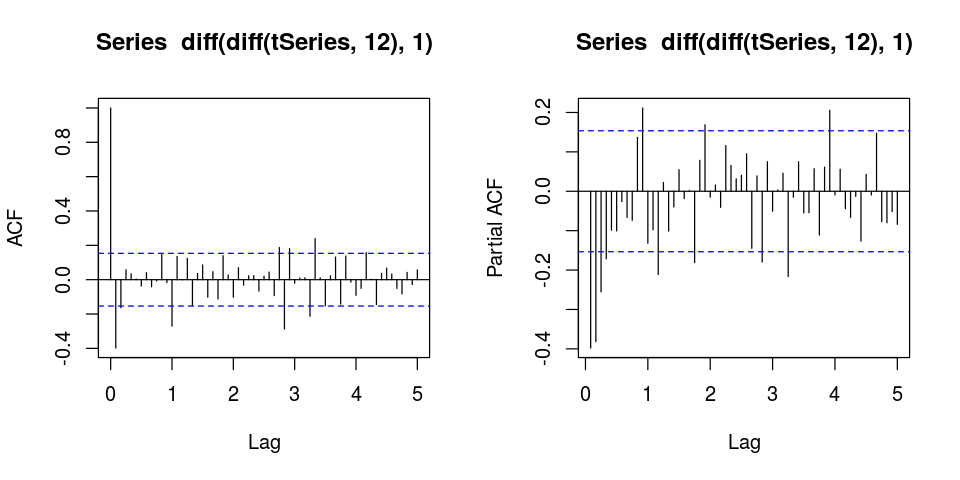

In [87]:
par(mfrow=c(1,2))
acf(diff(diff(tSeries, 12), 1), lag.max=5*12)
pacf(diff(diff(tSeries, 12), 1), lag.max=5*12)

На ACF значимы лаги 1 и 12, на PACF — 1-3. Будем искать модель, оптимальную по AICc, в окрестности ARIMA(3,1,1)(0,1,1)$_{12}$:

In [97]:
for (p in 0:4) {
    for (P in 0:1) {
        for (Q in 0:2) {
            print(c(p, P, Q, Arima(tSeries, order=c(p,1,1), seasonal=c(P,1,Q))$aicc))
        }
    }
}

[1]    0.000    0.000    0.000 3040.141
[1]    0.000    0.000    1.000 3004.469
[1]    0.000    0.000    2.000 3005.175
[1]    0.000    1.000    0.000 3015.907
[1]    0.000    1.000    1.000 3004.669
[1]    0.000    1.000    2.000 3005.985
[1]    1.000    0.000    0.000 3041.972
[1]    1.000    0.000    1.000 3004.999
[1]    1.000    0.000    2.000 3006.269
[1]    1.000    1.000    0.000 3017.159
[1]    1.000    1.000    1.000 3005.935
[1]    1.000    1.000    2.000 3007.252
[1]    2.000    0.000    0.000 3041.194
[1]    2.000    0.000    1.000 3002.116
[1]    2.000    0.000    2.000 3003.865
[1]    2.000    1.000    0.000 3013.391
[1]    2.000    1.000    1.000 3003.659
[1]    2.000    1.000    2.000 3004.969
[1]    3.000    0.000    0.000 3043.054
[1]    3.000    0.000    1.000 3004.005
[1]    3.000    0.000    2.000 3005.814
[1]    3.000    1.000    0.000 3015.518
[1]    3.000    1.000    1.000 3005.639
[1]    3.000    1.000    2.000 3007.054
[1]    4.000    0.000    0.000 3044.859


Наилучшая по AICc модель — ARIMA(2,1,1)(0,1,1)$_{12}$. Посмотрим на её остатки:

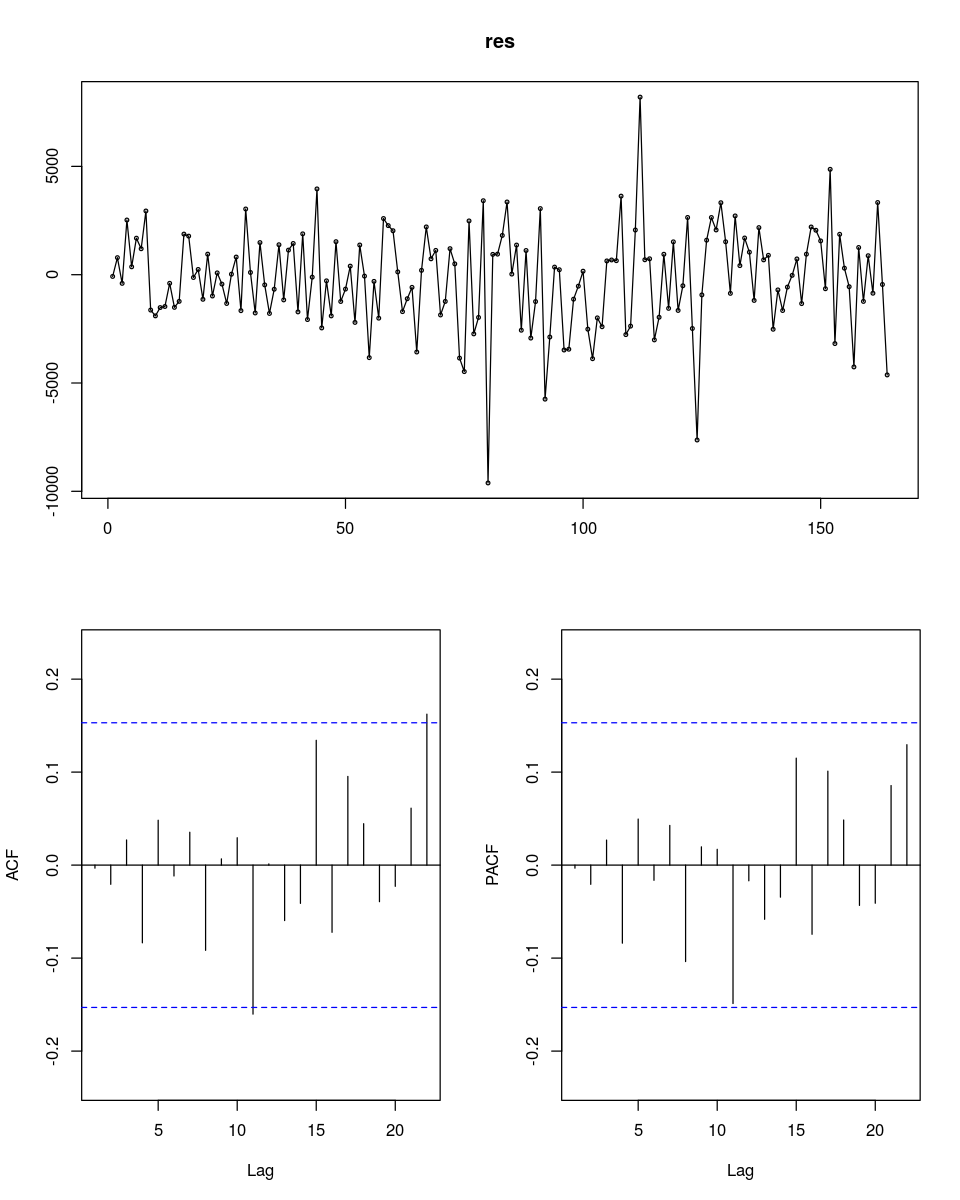

In [99]:
options(repr.plot.width = 8, repr.plot.height = 10)

fitARIMA <- Arima(tSeries, order=c(2,1,1), seasonal=c(0,1,1))
res <- residuals(fitARIMA)[-c(1:12)]
tsdisplay(res)

Достигаемые уровни значимости критерия Льюнга-Бокса для них:

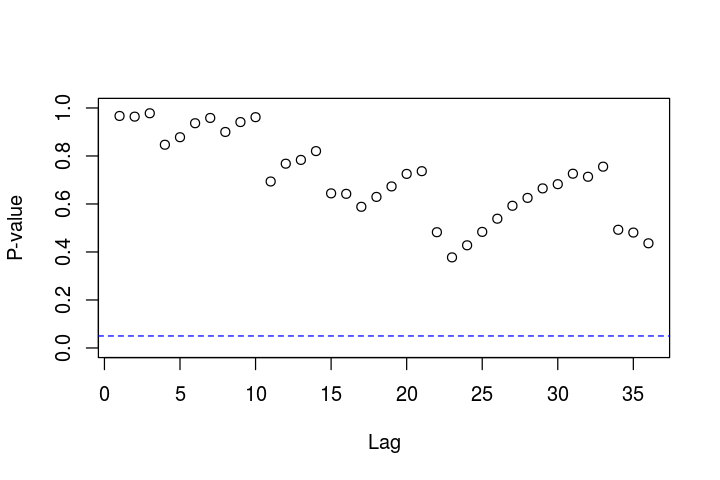

In [101]:
options(repr.plot.width = 6, repr.plot.height = 4)

p <- rep(0, 1, frequency(tSeries)*3)
for (i in 1:length(p)){
  p[i] <- Box.test(res, lag=i, type = "Ljung-Box")$p.value
}
plot(p, xlab="Lag", ylab="P-value", ylim=c(0,1))
abline(h = 0.05, lty = 2, col = "blue")

Q-Q plot и гистограмма для остатков:

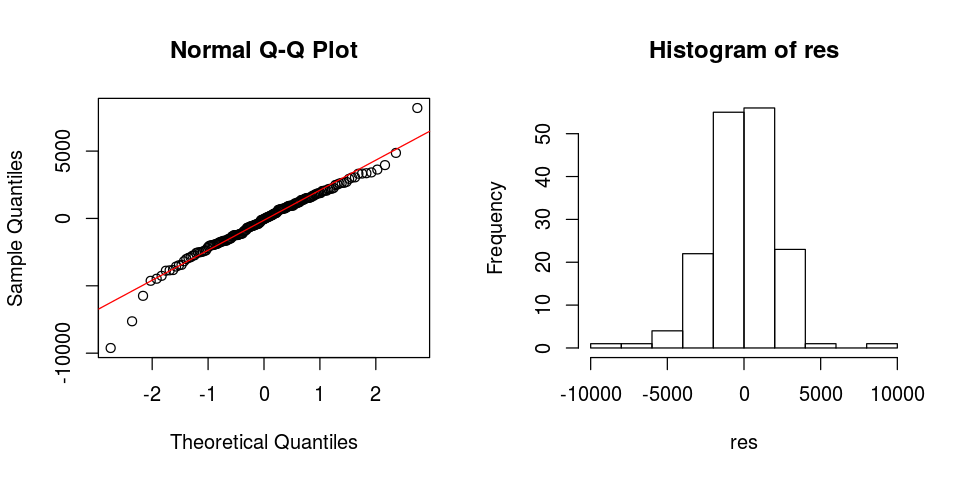

In [104]:
options(repr.plot.width = 8, repr.plot.height = 4)

par(mfrow=c(1,2))
qqnorm(res)
qqline(res, col="red")
hist(res)

На распределении остатков видны три выброса; скорее всего, из-за них гипотеза нормальности будет отклонена. 

In [105]:
shapiro.test(res)$p.value
wilcox.test(res)$p.value
kpss.test(res)$p.value
bptest(res ~ c(1:length(res)))$p.value

[1] 0.002118929

[1] 0.4858142

Warning message in kpss.test(res):
“p-value greater than printed p-value”

[1] 0.1

BP 
0.1031675

* Нормальность --- отвергается
* Несмещённость --- не отвергается
* Стационарность --- не отвергается
* Гомоскедастичность --- не отвергается 

Из-за отсутствия нормальности в итоговом прогнозе будем использовать предсказательные интервалы, полученные с помощью симуляции.

Настроив выбранную модель на обучающей выборке, посчитаем её качество на тестовой:

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-146.9891,2206.914,1612.259,-1.2133491,6.435847,0.8209235,0.0003823754,NA
Test set,131.4499,2013.327,1550.191,-0.3190162,6.460170,0.7893200,-0.2651320810,0.2910085


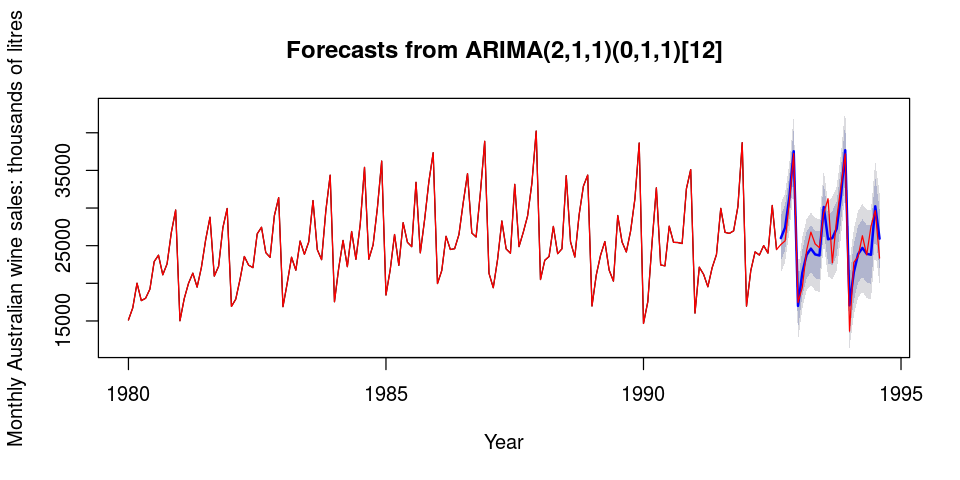

In [106]:
fitShort <- Arima(trainSeries, order=c(2,1,1), seasonal=c(0,1,1))
fc       <- forecast(fitShort, h=D)
accuracy(fc, testSeries)
plot(forecast(fitShort, h=D), ylab=xname, xlab="Year")
lines(tSeries, col="red")

### Автоматический подбор модели

`auto.arima(x, d=NA, D=NA, max.p=5, max.q=5,
            max.P=2, max.Q=2, max.order=5, max.d=2, max.D=1,
            start.p=2, start.q=2, start.P=1, start.Q=1,
            stationary=FALSE, seasonal=TRUE,
            ic=c("aicc","aic", "bic"), stepwise=TRUE, trace=FALSE,
            approximation=(length(x)>100 | frequency(x)>12), xreg=NULL,
            test=c("kpss","adf","pp"), seasonal.test=c("ocsb","ch"),
            allowdrift=TRUE, lambda=NULL, parallel=FALSE, num.cores=2)`

Применим функцию auto.arima:

In [107]:
fit.auto <- auto.arima(tSeries)
fit.auto

Series: tSeries 
ARIMA(1,1,2)(0,1,1)[12]                    

Coefficients:
         ar1      ma1     ma2     sma1
      0.4299  -1.4673  0.5339  -0.6600
s.e.  0.2984   0.2658  0.2340   0.0799

sigma^2 estimated as 5399312:  log likelihood=-1497.05
AIC=3004.1   AICc=3004.48   BIC=3019.57

Предлагается модель ARIMA(1,1,2)(0,1,1)$_{12}$. Её AICc выше, чем у модели, подобранной вручную.

Посмотрим на её остатки:

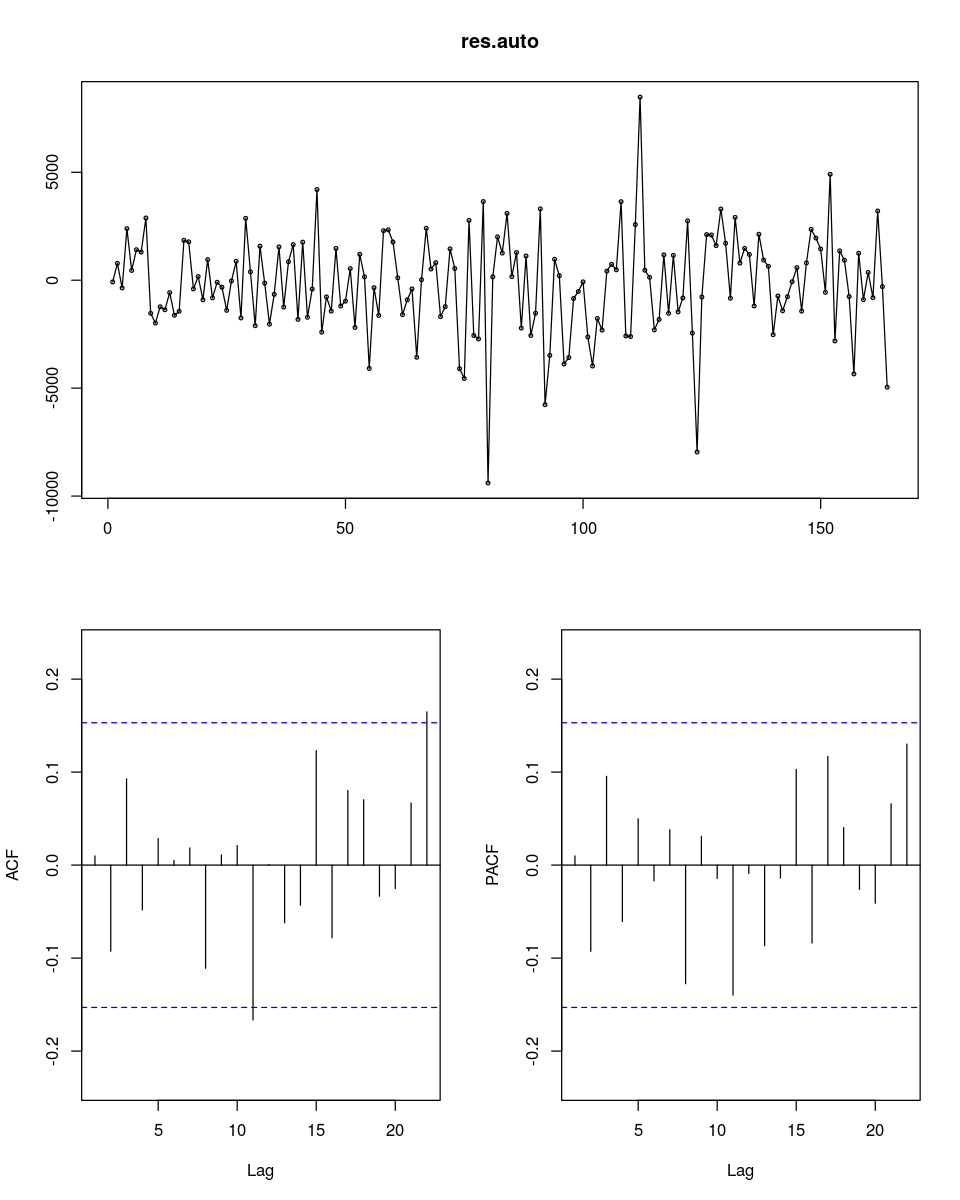

In [109]:
options(repr.plot.width = 8, repr.plot.height = 10)

res.auto <- residuals(fit.auto)[-c(1:12)]
tsdisplay(res.auto)

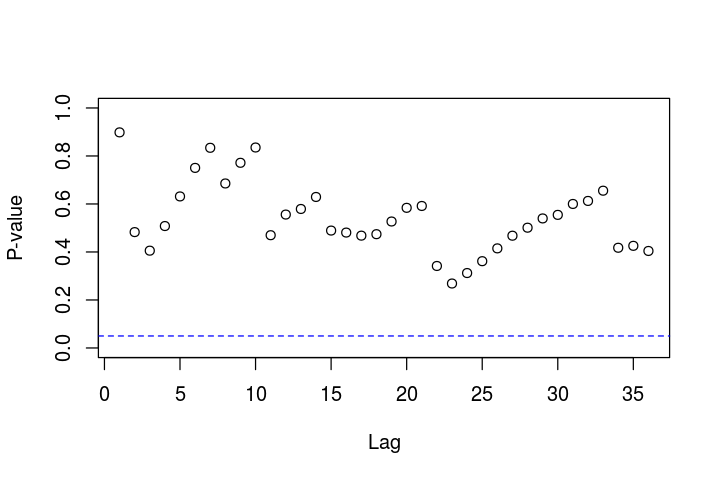

In [111]:
options(repr.plot.width = 6, repr.plot.height = 4)

p <- rep(0, 1, frequency(tSeries)*3)
for (i in 1:length(p)){
  p[i] <- Box.test(res.auto, lag=i, type = "Ljung-Box")$p.value
}
plot(p, xlab="Lag", ylab="P-value", ylim=c(0,1))
abline(h = 0.05, lty = 2, col = "blue")

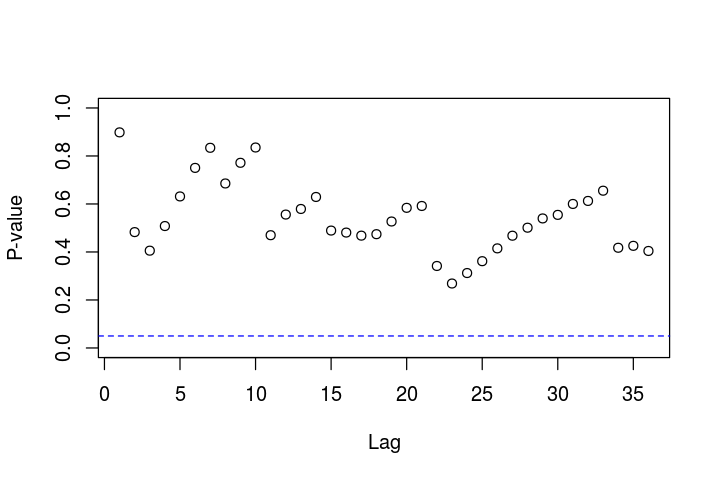

In [112]:
p <- rep(0, 1, frequency(tSeries)*3)
for (i in 1:length(p)){
  p[i] <- Box.test(res.auto, lag=i, type = "Ljung-Box")$p.value
}
plot(p, xlab="Lag", ylab="P-value", ylim=c(0,1))
abline(h = 0.05, lty = 2, col = "blue")

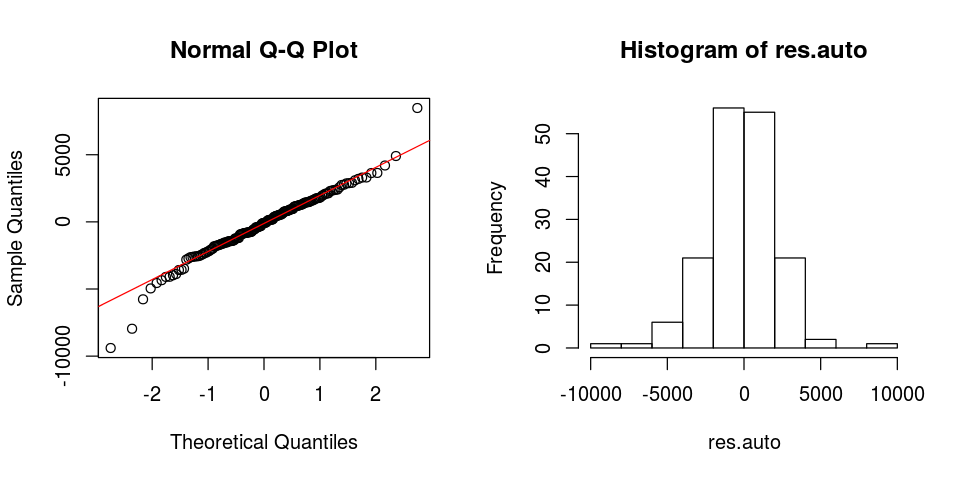

In [114]:
options(repr.plot.width = 8, repr.plot.height = 4)

par(mfrow=c(1,2))
qqnorm(res.auto)
qqline(res.auto, col="red")
hist(res.auto)

In [121]:
shapiro.test(res.auto)$p.value
wilcox.test(res.auto)$p.value
kpss.test(res.auto)$p.value
bptest(res.auto ~ c(1:length(res.auto)))$p.value

[1] 0.001307219

[1] 0.469525

Warning message in kpss.test(res.auto):
“p-value greater than printed p-value”

[1] 0.1

BP 
0.1027643

* Нормальность --- отвергается
* Несмещённость --- неотвергается
* Стационарность --- неотвергается
* Гомоскедастичность --- неотвергается 

Настроив выбранную модель на обучающей выборке, посчитаем её качество на тестовой:

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-165.2444,2155.839,1549.235,-1.241303,6.230774,0.7888332,-0.1242620,NA
Test set,467.3365,2031.128,1542.418,1.095043,6.359016,0.7853622,-0.2650403,0.3018453


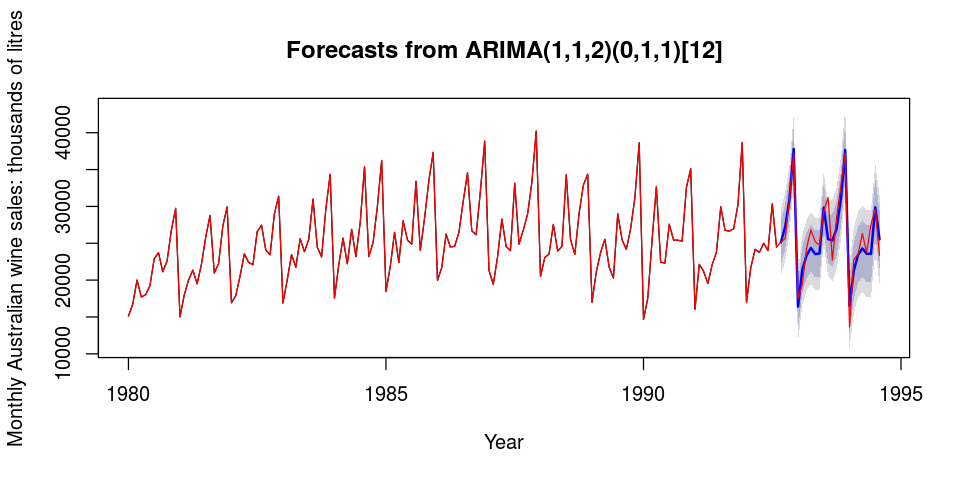

In [116]:
fitShort <- Arima(trainSeries, order=c(1,1,2), seasonal=c(0,1,1))
fc       <- forecast(fitShort, h=D)
accuracy(fc, testSeries)
plot(forecast(fitShort, h=D), ylab=xname, xlab="Year")
lines(tSeries, col="red")

Ошибка на тестовой выборке немного больше, чем у ручной аримы.


	Diebold-Mariano Test

data:  resres.auto
DM = -0.76014, Forecast horizon = 1, Loss function power = 2, p-value =
0.4483
alternative hypothesis: two.sided


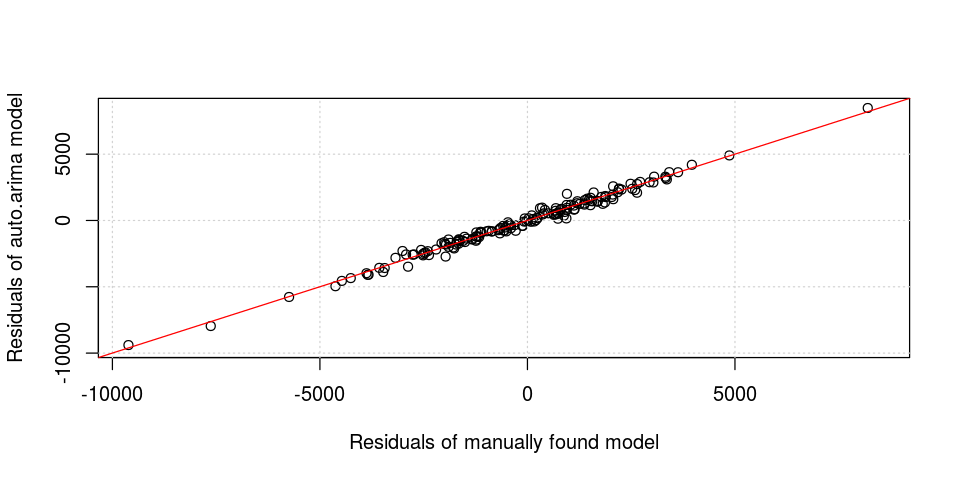

In [117]:
plot(res, res.auto, xlim=c(min(res, res.auto), max(res, res.auto)), ylim=c(min(res, res.auto), max(res, res.auto)), 
     xlab = "Residuals of manually found model", ylab="Residuals of auto.arima model")
grid()
lines(c(min(res, res.auto), max(res, res.auto))*2, c(min(res, res.auto), max(res, res.auto))*2, col="red")

dm.test(res, res.auto)

Остатки автоматической модели не лучше, а AICc и ошибка на тестовой выборке больше, так что остановимся на модели, подобранной вручную.

## Итоговое сравнение

Сравним остатки лучших моделей ARIMA и ETS:


	Diebold-Mariano Test

data:  resresETS[-c(1:12)]
DM = 0.71098, Forecast horizon = 1, Loss function power = 2, p-value =
0.4781
alternative hypothesis: two.sided


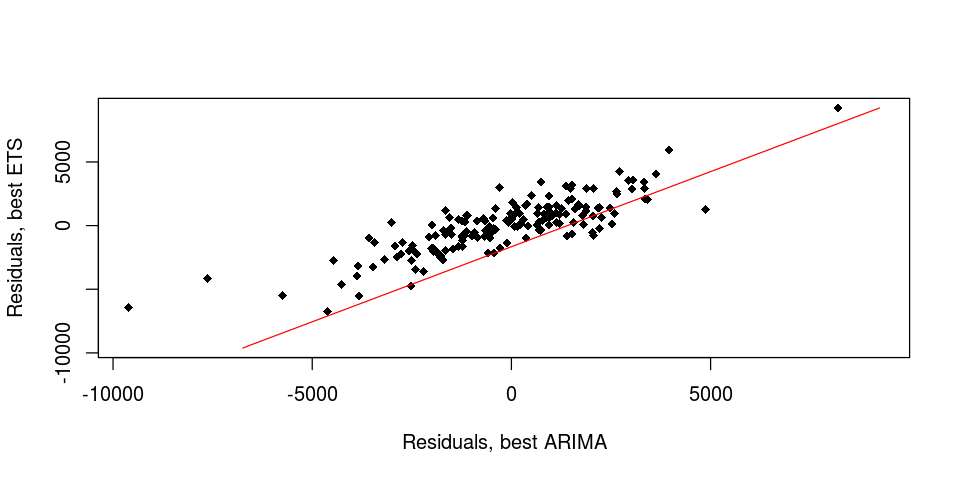

In [119]:
plot(res, resETS[-c(1:12)], pch=18,
     xlab="Residuals, best ARIMA",
     ylab="Residuals, best ETS",
     xlim=c(min(c(res, resETS), na.rm=T), max(c(res, resETS), na.rm=T)),
     ylim=c(min(c(res, resETS), na.rm=T), max(c(res, resETS), na.rm=T)))
 lines(c(min(c(resETS, resETS), na.rm=T), max(c(res, resETS), na.rm=T)), c(min(c(res, resETS), na.rm=T), max(c(res, resETS), na.rm=T)), col="red")

dm.test(res, resETS[-c(1:12)])

Остатки отличаются слабо, так что по ошибке на тестовой выборке выберем в качестве финальной модели подобранную вручную ARIMA.

Итоговый прогноз:

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Sep 1994       25356.74 23003.90 28005.30 21263.63 28936.96
Oct 1994       27989.79 25395.53 30402.90 23652.22 31742.72
Nov 1994       31665.12 29253.82 34235.13 27530.66 35303.62
Dec 1994       37258.26 34667.07 39731.30 32814.71 40960.25
Jan 1995       16105.65 13560.05 18696.46 11714.25 19986.72
Feb 1995       21432.22 18825.10 23976.44 17090.23 25414.07
Mar 1995       23880.70 21304.42 26525.26 19372.07 27796.82
Apr 1995       25849.25 23152.79 28474.01 21291.44 29774.95
May 1995       24153.19 21504.70 26741.80 19496.78 28057.69
Jun 1995       25291.29 22606.71 28033.04 20510.13 29372.46
Jul 1995       29805.99 27102.91 32510.24 25234.17 33996.48
Aug 1995       26377.73 23702.18 29090.30 21784.76 30463.70
Sep 1995       24885.24 21877.35 27979.93 19794.85 29558.44
Oct 1995       27545.71 24375.37 30626.66 22307.29 32240.07
Nov 1995       31895.07 28868.86 35053.94 26844.15 36679.39
Dec 1995       37369.80 34258.21 40456.2

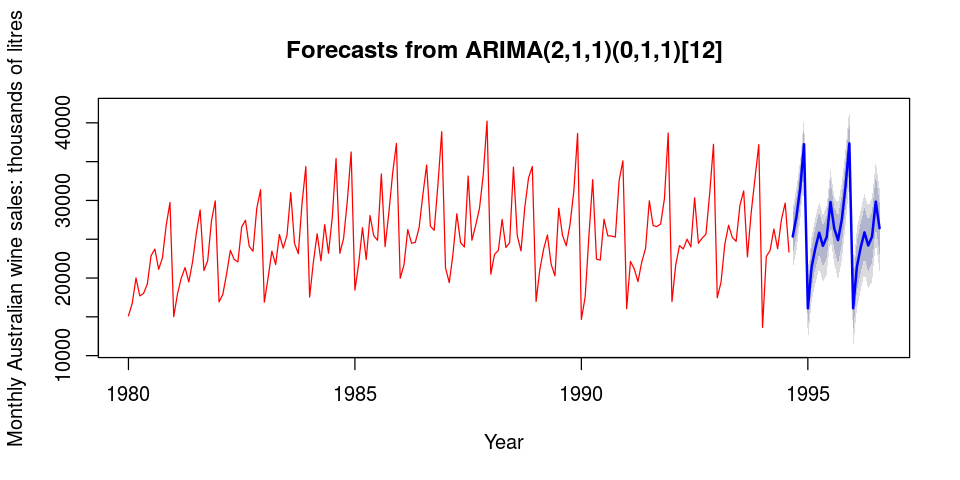

In [120]:
f <- forecast(fitARIMA, h=D, bootstrap=TRUE)
print(f)
plot(f, ylab=xname, xlab="Year", col="red")

https://yadi.sk/d/0uGoefdsotGX5